# 02.20.01 - DNN MFCC20 (60-10-30) SIGMOID

## Prerequisites

- The dataset exists (if not, execute 02.00)
- The dataset features have been populated (if not, execute 02.01)

## Goals

In this experiment, we get a first idea about the performance of a Dense Neural Network using MFCC coefficients as features, through a simple train/valid/test random split of the dataset.


## Conclusion

<p style="color:blue;"><b>TODO</b></p>

<hr style="border:1px solid gray"></hr>

### Step 1: Get previously created dataset

In [1]:
import warnings                      # This block prevents display of harmless warnings, but should be
warnings.filterwarnings('ignore')    # commented out till the experiment final version,
                                     # in order to avoid missing "real" warnings 

import kilroy_was_here               # Mandatory. Allow access to shared python code from repository root
from audace.jupytools import (
    iprint,                          # timestamped (to the ms) print with CPU and RAM consumption information
    predestination,                  # Seeds the various PRNGs for reproducibility 
    say_my_name                      # gets notebook name
)

from audace.audiodataset import AudioDataset      # Main class for audio dataset handling

#########################
# Experiment parameters #
#########################

EXP_NAME = say_my_name()  # Experiment name will be used to create outputs directory

DATASET_NAME = 'MAIN1000' # Dataset name is the master key for dataset addressing
                          # Change it according to the dataset you want to process

FEATURE_NAME = 'mfcc20'   # Name of the feature used for classification
LABEL_NAME = 'queen'      # Name of the label used for classification

VALID_FRAC = 0.1
TEST_FRAC  = 0.3


# Initialize Dataset Object. 
ds = AudioDataset(DATASET_NAME)
    
# Display AudioDataset summary    
ds.info()

# Build dataframe containing all the information needed to conduct the experiment
sql = F"SELECT {FEATURE_NAME}, {LABEL_NAME} FROM samples WHERE nobee = 0"
df = ds.queryDataFrame(sql)

# Display cardinalities by hive attribute and queen label for samples with no external perturbation
sql = """
    select distinct hive, queen, count(*)
    from samples
    where nobee = 0
    group by hive, queen
    order by hive
    """
ds.queryDataFrame(sql)

[2020-09-10/11:15:28.363|30.3%|78.2%|0.28GB] ------------------------------------------------------
[2020-09-10/11:15:28.365|00.0%|78.2%|0.28GB] DATASET NAME          : MAIN1000
[2020-09-10/11:15:28.365|00.0%|78.2%|0.28GB] DATASET PATH          : D:\Jupyter\ShowBees\datasets\MAIN1000
[2020-09-10/11:15:28.365|00.0%|78.2%|0.28GB] DATASET DB PATH       : D:\Jupyter\ShowBees\datasets\MAIN1000\MAIN1000.db
[2020-09-10/11:15:28.365|00.0%|78.2%|0.28GB] DATASET SAMPLES PATH  : D:\Jupyter\ShowBees\datasets\MAIN1000\samples
[2020-09-10/11:15:28.366|50.0%|78.2%|0.28GB] NB SOURCE AUDIO FILES : 48
[2020-09-10/11:15:28.366|00.0%|78.2%|0.28GB] SAMPLE RATE           : 22050
[2020-09-10/11:15:28.366|00.0%|78.2%|0.28GB] DURATION              : 1.0
[2020-09-10/11:15:28.367|00.0%|78.2%|0.28GB] OVERLAP               : 0.0
[2020-09-10/11:15:28.367|00.0%|78.2%|0.28GB] NB AUDIO CHUNKS       : 24788
[2020-09-10/11:15:28.367|00.0%|78.2%|0.28GB] ------------------------------------------------------


,hive,queen,count(*)
0,CF001,0.0,14
1,CF003,1.0,3649
2,CJ001,0.0,790
3,GH001,1.0,1396
4,Hive1,0.0,1473
5,Hive1,1.0,2684
6,Hive3,0.0,6545
7,Hive3,1.0,654


<hr style="border:1px solid gray"></hr>

### Step 2: Process DNN learning 

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from audace.splitters import splitTrainValidTest
from tensorflow import keras

def simple_model(n_inputs):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=n_inputs))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(4, activation="selu", kernel_initializer="lecun_normal"))
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy",
                  optimizer="nadam",
                  metrics=["accuracy"]
    )    
    
    return model


def get_run_logdir():
    import time
    from pathlib import Path
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return Path(EXP_NAME, 'logs', run_id)

# Seed the various PRNGs
predestination()

# Build training and test datasets
iprint(">>>>> Building partitions training/validation/test")
X_train, X_valid, X_test, y_train, y_valid, y_test = splitTrainValidTest(
    df,
    VALID_FRAC,
    TEST_FRAC,
    FEATURE_NAME,
    LABEL_NAME
)

# Standardize data 
iprint(">>>>> Standardize")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Build NN
iprint(">>>>> Build NN")
keras.backend.clear_session()
model = simple_model(X_train[0].shape)

iprint(F">>>>> Train on {len(X_train)}, validate on {len(X_valid)}, test on {len(X_test)}")
run_logdir = get_run_logdir()

tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

early_stopping_cb = keras.callbacks.EarlyStopping(
                        monitor='val_loss',
                        patience=20,
                        restore_best_weights=True
                    )

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, tensorboard_cb],
                    verbose=2
          )

[2020-09-10/11:15:29.867|26.1%|79.3%|0.35GB] >>>>> Building partitions training/validation/test
[2020-09-10/11:15:30.006|41.4%|79.9%|0.41GB] >>>>> Standardize
[2020-09-10/11:15:30.366|31.9%|80.2%|0.41GB] >>>>> Build NN
[2020-09-10/11:15:30.520|22.2%|80.1%|0.41GB] >>>>> Train on 10322, validate on 1721, test on 5162
Train on 10322 samples, validate on 1721 samples
Epoch 1/100
10322/10322 - 2s - loss: 0.1906 - accuracy: 0.9345 - val_loss: 0.0711 - val_accuracy: 0.9831
Epoch 2/100
10322/10322 - 1s - loss: 0.0461 - accuracy: 0.9897 - val_loss: 0.0405 - val_accuracy: 0.9861
Epoch 3/100
10322/10322 - 1s - loss: 0.0222 - accuracy: 0.9963 - val_loss: 0.0239 - val_accuracy: 0.9919
Epoch 4/100
10322/10322 - 1s - loss: 0.0131 - accuracy: 0.9983 - val_loss: 0.0256 - val_accuracy: 0.9907
Epoch 5/100
10322/10322 - 1s - loss: 0.0091 - accuracy: 0.9987 - val_loss: 0.0246 - val_accuracy: 0.9913
Epoch 6/100
10322/10322 - 1s - loss: 0.0070 - accuracy: 0.9990 - val_loss: 0.0193 - val_accuracy: 0.9924
Epoc

<hr style="border:1px solid gray"></hr>

### Step 3: Display learning report


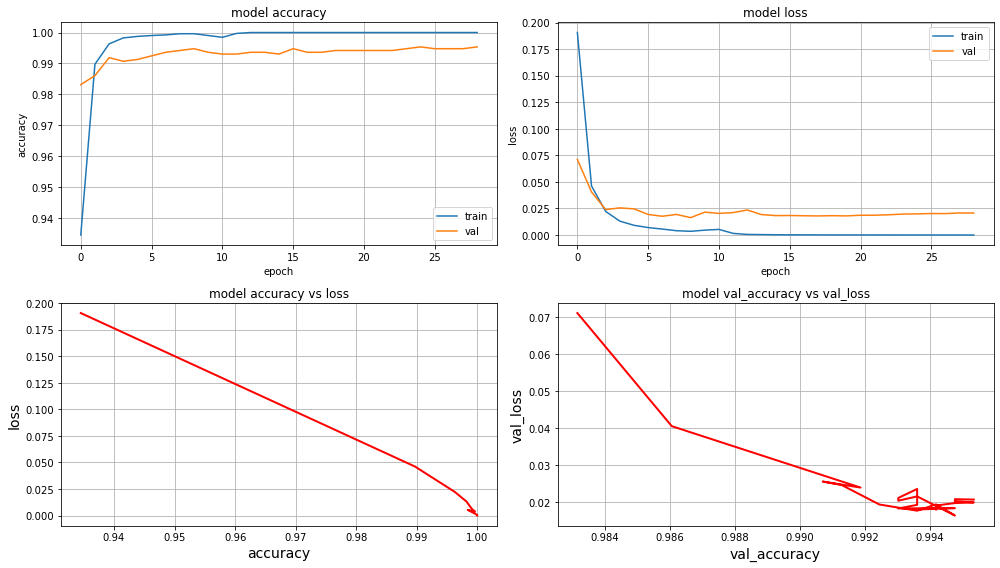

In [3]:
from audace.plotters import plot_nn_learning_curves

plot_nn_learning_curves(history, EXP_NAME, 'learning report')

<hr style="border:1px solid gray"></hr>

### Step 4: Display performance report


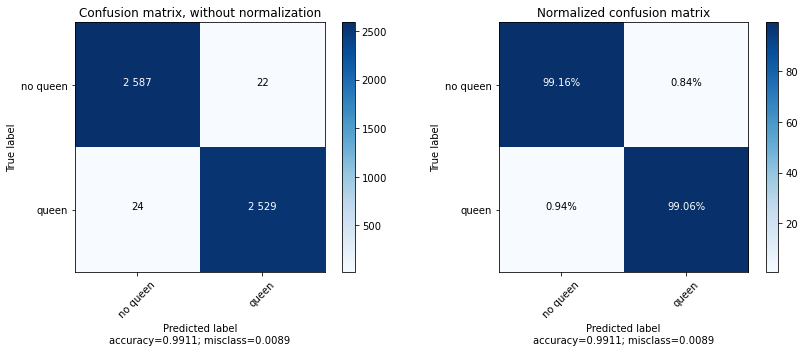

[2020-09-10/11:15:56.646|41.0%|80.9%|0.47GB] >>>>> Predict
[2020-09-10/11:15:57.012|46.2%|80.9%|0.47GB] loss: 0.021823536855334988
[2020-09-10/11:15:57.013|00.0%|80.9%|0.47GB] accuracy: 0.9910887479782104
[2020-09-10/11:15:57.221|42.3%|80.9%|0.47GB] ans: 1.0 / acc: 0.99109


In [4]:
from audace.metrics import i_may_be_wrong
from audace.plotters import nn_full_report

nn_full_report(model, X_test, y_test, ['no queen', 'queen'], EXP_NAME, 'confusion matrix')

#Predict the response for test dataset
iprint('>>>>> Predict')
y_pred = model.predict(X_test)
scores = model.evaluate(X_test, y_test, verbose=0)

for i in range(len(scores)):
    iprint(F"{model.metrics_names[i]}: {scores[i]}")
    
    
ans, acc = i_may_be_wrong(model, X_test, y_test, 0.01, 0.99)
iprint(F"ans: {round(ans,5)} / acc: {round(acc,5)}")  

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 880)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 3524      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 3,549
Trainable params: 3,549
Non-trainable params: 0
_________________________________________________________________
